# Analyze accident reports on Amazon EMR Spark

This notebook shows you how to analyze car vehicle accidents based on accident reports for New York on Amazon EMR™ Spark in Data Science Experience. You will learn how to install additional Python packages, how to adjust your environment to use Amazon EMR Spark, how to load data from Amazon S3™ using Spark, and how to create visualizations.

This notebook runs on Python 2 on Amazon Elastic Map Reduce (EMR) with Spark 2.1.

Note: Some of the sample output graphs created with Brunel that you can see in the preview of this notebook don't appear when you edit the notebook because they are blocked by the IPython security model. Graphs that you and your collaborators create are always visible.

Table of contents:
- [Setup](#setup)
- [Get data](#data)
- [Install packages](#install-packages)
- [Import packages and adjust environment](#adjust-env)
- [Load data from S3](#load-data-s3)
- [Explore and visualize data](#explore-data)
- [Summary](#summary)

<a id="setup"></a>
## Setup

Before you can run code in this notebook, you must have created an EMR cluster and set up a Jupyter Kernel Gateway to the EMR Spark cluster. Then you must associate your project with the Kernel Gateway web server to Amazon EMR. For details on setting up Amazon EMR in Data Science Experience, see <a href="https://apsportal.ibm.com/docs/content/analyze-data/aws-emr.html" target="_blank" rel="noopener noreferrer">Running notebooks on Amazon EMR</a>.

The car vehicle accident data you will analyze must be stored in an Amazon S3 bucket which you must have created. For details on how to create a bucket in Amazon S3, see <a href="http://docs.aws.amazon.com/AmazonS3/latest/gsg/SigningUpforS3.html" target="_blank" rel="noopener noreferrer">Amazon Simple Storage Service</a>.


<a id="data"></a>
## Get data

Begin by getting the data about car accidents in the New York area. The data set is publicaly available on NYC OpenData and covers all reported vehicle collisions in New York starting in July 2012 until today. 

1.  Click [NYPD Motor Vehicle Collisions](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95) to access the data set. 
1.  Click **Export** to download the data as a CSV file to your local machine. 
1.  Then load the data set to your Amazon S3 storage.

<a id="install-packages"></a>
## Install packages

To handle and plot your data, this notebook will use the following Python packages, which you need to install by using `!pip`:

- [pandas](http://pandas.pydata.org/): for storing and handling data in memory
- [seaborn](https://seaborn.pydata.org/): for enhancing the `matplotlib` color schemes or creating statistical plots
- [jupyter-pip](https://pypi.python.org/pypi/jupyter-pip): for installing `brunel`
- [brunel](https://pypi.python.org/pypi/brunel): for creating interactive or more complex plots

In [6]:
!pip install --user pandas

You are using pip version 6.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
# needs to be set for matplotlib and seaborn
os.environ['LANG'] = "en_US.UTF-8"
os.environ['LC_ALL'] = "en_US.UTF-8"

In [8]:
!pip install --user seaborn

You are using pip version 6.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip install --user jupyter-pip

You are using pip version 6.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
!pip install --user brunel

You are using pip version 6.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<a id="adjust-env"></a>
## Import packages and adjust environment

Import the libraries you'll be using in the notebook, set required variables, and define customizations:  

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# needs to be set for brunel before the import
#os.environ['BRUNEL_CONFIG'] = "locjavascript=https://cdsx-jupyter-notebooks-converter.ng.bluemix.net/data/jupyter2/x-x-x-x-x/nbextensions/brunel_ext/"
os.environ['BRUNEL_CONFIG'] = "locjavascript=/data/jupyter2/static-file-content-delivery-network/nbextensions/brunel_ext"
import brunel

# needs to be set for matplotlib and seaborn
os.environ['LANG'] = "en_US.UTF-8"
os.environ['LC_ALL'] = "en_US.UTF-8"

# enables inline plotting in the notebook
%matplotlib inline

# set seaborn style for matplotlib plots
sns.set_style("white")

/home/kernelgateway/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<a id="load-data-s3"></a>
## Load data from S3

You will use `SparkSession`, which is available starting with Spark 2.0, to interact with Spark functionality and read the CSV file.

Load the NYPD motor vehicle collisions data set from Amazon S3 into a Spark `DataFrame`. You must specify the name of the S3 bucket you created:

In [3]:
spark = SparkSession.builder.getOrCreate()

bucket_name = "your-bucket" # fill in the name of your S3 bucket
file_name = "NYPD_Motor_Vehicle_Collisions.csv" # fill in the name of your CSV file
path = "".join(['s3://', bucket_name, '/', file_name])

collisions_spark_df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load(path)
collisions_spark_df.cache()
collisions_spark_df.take(1)

[Row(DATE=u'01/29/2016', TIME=u'12:50', BOROUGH=u'QUEENS', ZIP CODE=11417, LATITUDE=40.6702271, LONGITUDE=-73.845482, LOCATION=u'(40.6702271, -73.845482)', ON STREET NAME=u'LAFAYETTE STREET', CROSS STREET NAME=u'149 AVENUE', OFF STREET NAME=None, NUMBER OF PERSONS INJURED=0, NUMBER OF PERSONS KILLED=0, NUMBER OF PEDESTRIANS INJURED=0, NUMBER OF PEDESTRIANS KILLED=0, NUMBER OF CYCLIST INJURED=0, NUMBER OF CYCLIST KILLED=0, NUMBER OF MOTORIST INJURED=0, NUMBER OF MOTORIST KILLED=0, CONTRIBUTING FACTOR VEHICLE 1=u'Driver Inattention/Distraction', CONTRIBUTING FACTOR VEHICLE 2=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 3=None, CONTRIBUTING FACTOR VEHICLE 4=None, CONTRIBUTING FACTOR VEHICLE 5=None, UNIQUE KEY=3379731, VEHICLE TYPE CODE 1=u'SPORT UTILITY / STATION WAGON', VEHICLE TYPE CODE 2=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 3=None, VEHICLE TYPE CODE 4=None, VEHICLE TYPE CODE 5=None)]

<a id="explore-data"></a>
## Explore and visualize data
Now that the data is loaded, you can start exploring it and visualizing patterns by using the Spark API and the previous installed packages.

Begin by displaying the inferred schema for the Spark DataFrame:

In [4]:
collisions_spark_df.printSchema()

root
 |-- DATE: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string (nulla

Run the following cell to count the number of vehicle collisions:

In [5]:
collisions_spark_df.count()

744246

Select the columns with data that you want to explore and transform these columns into a `pandas.DataFrame`:

In [6]:
collisions_pd_df = collisions_spark_df[collisions_spark_df['LATITUDE'] != 0][['LATITUDE', 'LONGITUDE', 'DATE', 'TIME',
                                                               'BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME',
                                                               'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                                                               'CONTRIBUTING FACTOR VEHICLE 1']].toPandas()

collisions_pd_df.columns = ['Latitude', 'Longitude', 'Date', 'Time', 'Borough', 'On Street',
                         'Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

killed_pd_df = collisions_pd_df[collisions_pd_df['Persons Killed']!=0]
injured_pd_df = collisions_pd_df[np.logical_and(collisions_pd_df['Persons Injured']!=0, collisions_pd_df['Persons Killed']==0)]
nothing_pd_df = collisions_pd_df[np.logical_and(collisions_pd_df['Persons Killed']==0, collisions_pd_df['Persons Injured']==0)]

### Create a scatter plot of the data

Using a scatter plot is a way to analyze certain characteristics of the raw data. You can plot all collisions by using the latitude and longitude information.

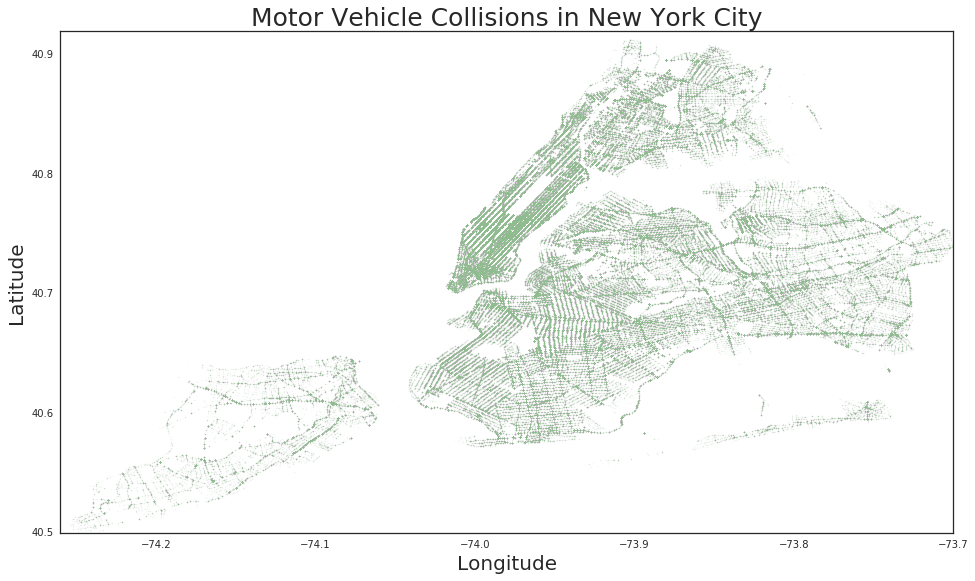

In [7]:
plt.figure(figsize=(16,9))
plt.scatter(collisions_pd_df.Longitude, collisions_pd_df.Latitude, alpha=0.05, s=1, color='darkseagreen')
plt.title('Motor Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

Although this scatter plot is not a street map of New York City, the scatter plot dots roughly correspond to the street map of New York City. You see very few collisions in Central Park or on bridges, as opposed to street crossings and curves, where there is a noticeably higher density of collisions.

### Create a bar graph to  visualize patterns

In the next cell, run the `groupBy` and the `count` functions on the Spark cluster and tranform the result into a `pandas.DataFrame` for plotting.

In [8]:
borough_df = collisions_spark_df.groupBy('BOROUGH').count().sort('count').toPandas()
borough_df.head(6)

,BOROUGH,count
0,STATEN ISLAND,26703
1,BRONX,71922
2,QUEENS,145411
3,MANHATTAN,148967
4,BROOKLYN,172906
5,None,178337


As you can see in the output above, there are incidences that cannot be associated with a borough. For further visualizations, replace the value 'None' with the value 'NOT KNOWN'.

In [9]:
borough_df.set_value(5, 'BOROUGH', 'NOT KNOWN')

,BOROUGH,count
0,STATEN ISLAND,26703
1,BRONX,71922
2,QUEENS,145411
3,MANHATTAN,148967
4,BROOKLYN,172906
5,NOT KNOWN,178337


Create a bar graph to show the total number of collisions by borough.

In [10]:
%brunel data('borough_df') bar x(BOROUGH) y(count)

<IPython.core.display.Javascript object>

### Create a bubble chart for proportional comparison

Create a bubble chart to show the proportions of collisions by borough. The larger the bubbles, the higher the number of  collisions. You sort the data by using different colors for each borough.

In [11]:
%brunel data('borough_df') bubble x(BOROUGH) color(BOROUGH) size(count) label(BOROUGH) sum(count) legends(none)

<IPython.core.display.Javascript object>

The bar graph and the bubble chart both clearly show that the most collisions happen in Brooklyn and the least on Staten Island.

<a id="summary"></a>
## Summary

This notebook showed you how to analyze data stored in Amazon S3 in Amazon EMR. You learned how to import and load libraries, how to access your data in Amazon S3, and explore and visualize this data by using Amazon EMR Spark. 

### Author
Sven Hafeneger is a member of the Data Science Experience development team at IBM Watson and Cloud in Germany. He holds a M.Sc. in Bioinformatics and is passionate about data analysis, machine learning and the Python ecosystem for data science.

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.